# Predicting IKEA's features

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#prep">Imports and preperations</a></li>
<li><a href="#model_1">Model 1</a></li>
<li><a href="#model_2">Model 2</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='prep'></a>
## Imports and preperations

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import utils
from np_utils import *

%matplotlib inline

In [2]:
df = pd.read_csv('clean_IKEA_dataset.csv')
df.head()

,category,price,old_price,sellable_online,other_colors,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
0,Bar furniture,265.0,265.0,True,No,46.925926,99.000000,51.000000,0,1,1,0,0.0,5049.0
1,Bar furniture,995.0,995.0,False,No,46.925926,105.000000,80.000000,0,1,1,0,0.0,8400.0
2,Bar furniture,2095.0,2095.0,False,No,46.925926,97.571429,52.945946,0,0,0,0,0.0,1.0
3,Bar furniture,69.0,69.0,True,Yes,50.000000,100.000000,60.000000,0,1,1,1,0.0,300000.0
4,Bar furniture,225.0,225.0,True,No,60.000000,43.000000,74.000000,0,1,1,1,0.0,190920.0


In [3]:
scaler = MinMaxScaler()

df[['size', 'width', 'height', 'depth', 'discount_amount','price']] = scaler.fit_transform(df[['size', 'width', 'height', 'depth', 'discount_amount','price']])
df.head()

,category,price,old_price,sellable_online,other_colors,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
0,Bar furniture,0.027343,265.0,True,No,0.179398,0.140200,0.119332,0,1,1,0,0.0,0.000370
1,Bar furniture,0.103527,995.0,False,No,0.179398,0.148784,0.188544,0,1,1,0,0.0,0.000616
2,Bar furniture,0.218326,2095.0,False,No,0.179398,0.138157,0.123976,0,0,0,0,0.0,0.000000
3,Bar furniture,0.006888,69.0,True,Yes,0.191406,0.141631,0.140811,0,1,1,1,0.0,0.022012
4,Bar furniture,0.023168,225.0,True,No,0.230469,0.060086,0.174224,0,1,1,1,0.0,0.014008


In [4]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(df.category)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y)


In [5]:
df_train , df_test, dummy_y_train, dummy_y_test = train_test_split(df, dummy_y, shuffle=True, test_size=0.3)

<a id='model_1'></a>
## Model 1: Item's price prediction

In [20]:
feature_columns = []

discount_amount = tf.feature_column.numeric_column("discount_amount")
feature_columns.append(discount_amount)

size = tf.feature_column.numeric_column("size")
feature_columns.append(size)

width = tf.feature_column.numeric_column("width")
feature_columns.append(width)

height = tf.feature_column.numeric_column("height")
feature_columns.append(height)

depth = tf.feature_column.numeric_column("depth")
feature_columns.append(depth)

width_d = tf.feature_column.numeric_column("width_d")
feature_columns.append(width_d)

height_d = tf.feature_column.numeric_column("height_d")
feature_columns.append(height_d)

depth_d = tf.feature_column.numeric_column("depth_d")
feature_columns.append(depth_d)

other_colors = tf.feature_column.categorical_column_with_vocabulary_list(
    key='other_colors', vocabulary_list=('Yes', 'No'), default_value=0)
feature_columns.append(tf.feature_column.indicator_column(other_colors))

category = tf.feature_column.categorical_column_with_vocabulary_list(
    key='category', vocabulary_list=('Bar furniture', 'Beds', 'Bookcases & shelving units',
                                     'Cabinets & cupboards', 'Café furniture', 'Chairs',
                                     'Chests of drawers & drawer units', "Children's furniture",
                                     'Nursery furniture', 'Outdoor furniture', 'Room dividers',
                                     'Sideboards, buffets & console tables', 'Sofas & armchairs',
                                     'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes'),
    default_value=0)
feature_columns.append(tf.feature_column.indicator_column(category))

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [21]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [22]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.0),
                                  name='Hidden1'))
  
  # Define the second hidden layer with 10 nodes. 
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.0),
                                  name='Hidden2'))

  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1289/1289 [==============================] - 2s 934us/step - loss: 0.0156 - mean_squared_error: 0.01560s - loss: 0.021
Epoch 2/20
1289/1289 [==============================] - 1s 856us/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 3/20
1289/1289 [==============================] - 1s 888us/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 4/20
1289/1289 [==============================] - 1s 846us/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 5/20
1289/1289 [==============================] - 1s 883us/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 6/20
1289/1289 [==============================] - 1s 846us/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 7/20
1289/1289 [==============================] - 1s 967us/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 8/20
1289/1289 [==============================] - 1s 874us/step - loss

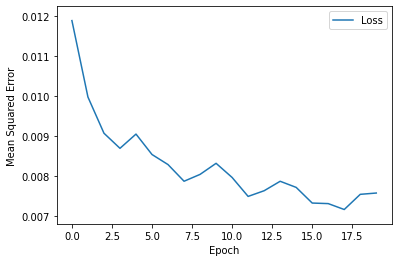


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
553/553 [==============================] - 1s 780us/step - loss: 0.0080 - mean_squared_error: 0.0080


[0.007959499023854733, 0.007959499023854733]

In [23]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 2


# Specify the label
label_name = "price"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, df_train, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in df_test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

<a id='model_2'></a>
## Model 2: Category classifier

In [24]:
feature_columns = []

price = tf.feature_column.numeric_column("price")
feature_columns.append(price)

discount_amount = tf.feature_column.numeric_column("discount_amount")
feature_columns.append(discount_amount)

size = tf.feature_column.numeric_column("size")
feature_columns.append(size)

width = tf.feature_column.numeric_column("width")
feature_columns.append(width)

height = tf.feature_column.numeric_column("height")
feature_columns.append(height)

depth = tf.feature_column.numeric_column("depth")
feature_columns.append(depth)

width_d = tf.feature_column.numeric_column("width_d")
feature_columns.append(width_d)

height_d = tf.feature_column.numeric_column("height_d")
feature_columns.append(height_d)

depth_d = tf.feature_column.numeric_column("depth_d")
feature_columns.append(depth_d)

other_colors = tf.feature_column.categorical_column_with_vocabulary_list(
    key='other_colors', vocabulary_list=('Yes', 'No'), default_value=0)
feature_columns.append(tf.feature_column.indicator_column(other_colors))


my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [25]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [27]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(my_feature_layer)

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=500, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))

  model.add(tf.keras.layers.Dense(units=200, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))

  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))


  # Output Layer
  model.add(tf.keras.layers.Dense(units=17, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, dataset, train_label, epochs,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))


  history = model.fit(x=features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)

  return epochs, hist

Epoch 1/200
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
860/860 [==============================] - 2s 2ms/step - loss: 2.5498 - accuracy: 0.2031
Epoch 2/200
860/860 [==============================] - 2s 2ms/step - loss: 2.0904 - accuracy: 0.3416
Epoch 3/200
860/860 [==============================] - 2s 2ms/step - loss: 1.8639 - accuracy: 0.3924
Epoch 4/200
860/860 [==============================] - 2s 2ms/step - loss: 1.7371 - accuracy: 0.4366
Epoch 5/200
860/860 [==============================] - 2s 2ms/step - loss: 1.5989 - accuracy: 0.4704
Epoch 6/200
860/860 [==============================] - 2s 2ms/step - loss: 1.5333 - accuracy: 0.4976
Epoch 7/200
860/860 [==============================] - 2s 2ms/step - loss: 1.5167 - accuracy: 0.4865
Epoch 8/200
860/860 [==============================] - 2s 2ms/step - loss: 1.4099 - accuracy: 0.5401
Epoch 9/200
860/860 [==============================] - 2s 2ms/step - loss: 1.4340 

860/860 [==============================] - 2s 2ms/step - loss: 0.9244 - accuracy: 0.6871
Epoch 137/200
860/860 [==============================] - 1s 2ms/step - loss: 0.9038 - accuracy: 0.6809
Epoch 138/200
860/860 [==============================] - 1s 2ms/step - loss: 0.8476 - accuracy: 0.7088
Epoch 139/200
860/860 [==============================] - 1s 2ms/step - loss: 0.9163 - accuracy: 0.6767
Epoch 140/200
860/860 [==============================] - 1s 2ms/step - loss: 0.8930 - accuracy: 0.6820
Epoch 141/200
860/860 [==============================] - 1s 2ms/step - loss: 0.8911 - accuracy: 0.6788
Epoch 142/200
860/860 [==============================] - 2s 2ms/step - loss: 0.9069 - accuracy: 0.6676
Epoch 143/200
860/860 [==============================] - 2s 2ms/step - loss: 0.9203 - accuracy: 0.6822
Epoch 144/200
860/860 [==============================] - 2s 2ms/step - loss: 0.8977 - accuracy: 0.6856
Epoch 145/200
860/860 [==============================] - 2s 2ms/step - loss: 0.8778 - a

[0.9891471266746521, 0.6880651116371155]

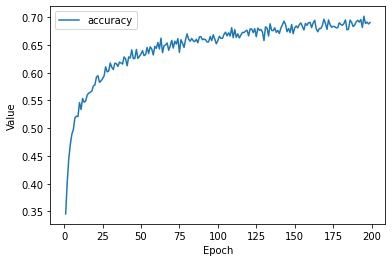

In [28]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 200
batch_size = 3


label_name = "category"
# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, df_train, dummy_y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
features = {name:np.array(value) for name, value in df_test.items()}

my_model.evaluate(x=features, y=dummy_y_test, batch_size=batch_size)